In [66]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import palantir
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import anndata
import seaborn as sns
import cellrank as cr
from adjustText import adjust_text

from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import spmatrix

from moscot.problems.time import TemporalProblem
from cellrank.kernels import RealTimeKernel
from cellrank.kernels import PseudotimeKernel


sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 1
sc.logging.print_version_and_date()

plt.rcParams['figure.figsize'] = [6, 6]

Running Scanpy 1.10.2, on 2024-11-12 11:40.


In [3]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
print(matplotlib.__version__)

colors = ["#FFFFFF", "#006199", "#DA4948"]
custom_cmap = LinearSegmentedColormap.from_list("custom_wbr", colors)
plt.colormaps.register(name="custom_wbr", cmap=custom_cmap)

colors = ["#0c0d0c", "#006199", "#EED365", "#DA4948"]
custom_cmap = LinearSegmentedColormap.from_list("custom_bbyr", colors)
plt.colormaps.register(name="custom_bbyr", cmap=custom_cmap)

colors = ["#006199", "#DA4948"]
custom_cmap = LinearSegmentedColormap.from_list("custom_br", colors)
plt.colormaps.register(name="custom_br", cmap=custom_cmap)

colors = ["#006199", "#70c269", "#DA4948"]
custom_cmap = LinearSegmentedColormap.from_list("custom_btr", colors)
plt.colormaps.register(name="custom_btr", cmap=custom_cmap)

colors = ["#006199", "#70c269", "#EED365", "#DA4948"]
custom_cmap = LinearSegmentedColormap.from_list("custom_btry", colors)
plt.colormaps.register(name="custom_btry", cmap=custom_cmap)

3.9.1.post1


In [4]:
import matplotlib.font_manager as fm

#Add the font explicitly
font_path = '/home/uvictor/miniconda3/envs/cellrank-palantir/fonts/bahnschrift.ttf'
fm.fontManager.addfont(font_path)

# Clear the font cache and rebuild it
fm._load_fontmanager(try_read_cache=False)

#Set font to Matplotlib
#Force unicode minus because Bahnschrift does not contain - sign

plt.rcParams['font.family'] = 'bahnschrift'
plt.rcParams['axes.unicode_minus'] = False


In [69]:
output_dir = "/mnt/f/CellRank/Ubels24/D.Papilla"

#adata = anndata.read_h5ad('/mnt/f/scRNA_output/Ubels_24/Ubels24_Follicle_scRNA.h5ad')

In [6]:
clusters_to_keep = ['D.Papilla']
adata_DP = adata[adata.obs['FineClust'].isin(clusters_to_keep)].copy()

In [7]:
# Check the unique clusters in your subset
print("Clusters in subset:", adata_DP.obs['FineClust'].unique())

# Check number of cells
print("Original cells:", adata.n_obs)
print("Cells in subset:", adata_DP.n_obs)

Clusters in subset: ['D.Papilla']
Categories (1, object): ['D.Papilla']
Original cells: 22130
Cells in subset: 630


In [8]:
adata_DP

AnnData object with n_obs × n_vars = 630 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'pANN_0.25_0.18_1115', 'DF.classifications_0.25_0.18_1115', 'Singlet', 'estConp', 'diseaseStatus', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'Clusters', 'NamedClust', 'BroadClust', 'SubGroup', 'sample', 'FineClust', 'BigClust', 'pANN_0.25_0.3_254', 'DF.classifications_0.25_0.3_254', 'pANN_0.25_0.27_160', 'DF.classifications_0.25_0.27_160', 'RNA_snn_res.0.5'
    obsm: 'X_umap'

In [9]:
sc.pp.normalize_total(adata_DP)
sc.pp.log1p(adata_DP)
sc.pp.highly_variable_genes(adata_DP, batch_key="diseaseStatus")

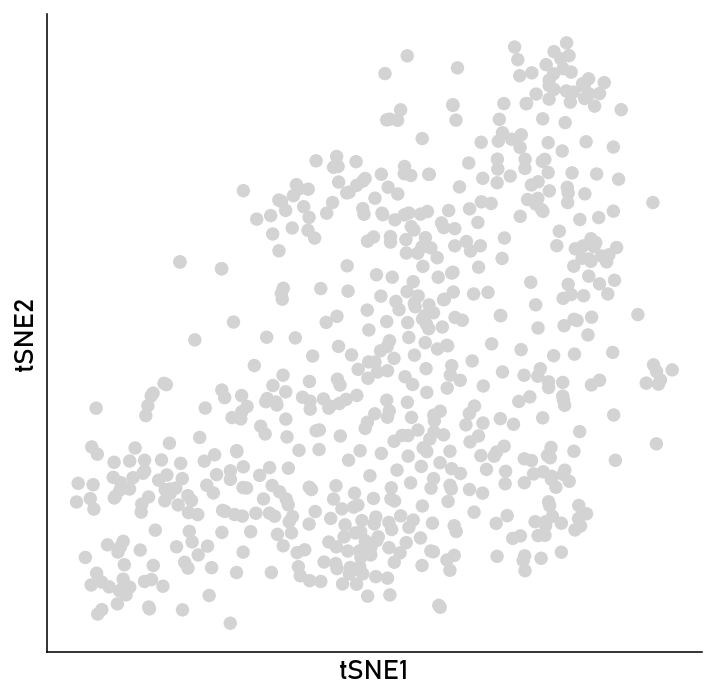

In [10]:
# Run highly variable genes 
sc.pp.pca(adata_DP)
sc.tl.tsne(adata_DP)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


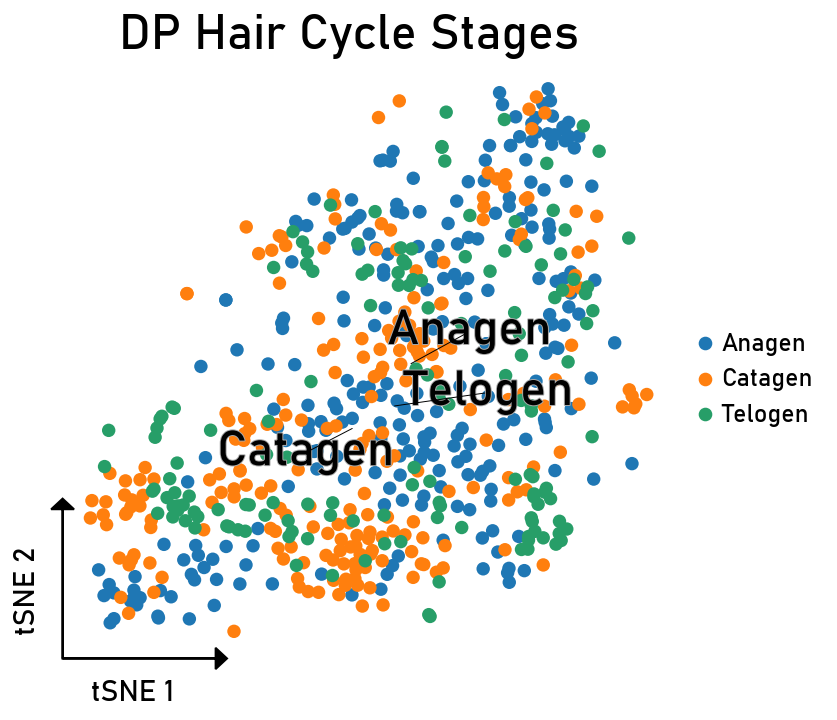

In [11]:
def plot_tsne_with_labels(adata_bulge, color_var, plot_title, legend_fontsize, figsize):
    """
    Create a tSNE plot with non-overlapping labels.
    
    Parameters:
    -----------
    adata_bulge : AnnData
        Annotated data matrix
    color_var : str
        Variable name in adata_bulge.obs for coloring groups
    plot_title : str
        Title for the plot
    figsize : tuple, optional
        Figure size (width, height) in inches
    dpi : int, optional
        Figure resolution
        
    Returns:
    --------
    matplotlib.axes.Axes
        The plot axes
    """
    with plt.rc_context({"figure.figsize": figsize, "figure.frameon": False}):
        # Create base tSNE plot
        ax = sc.pl.tsne(adata_bulge,
                        color=[color_var],
                        show=False,
                        frameon=True)
        
        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        # Set title and labels
        ax.set_title(plot_title, fontsize=25)
        ax.set_xlabel('tSNE 1', fontsize=15)
        ax.set_ylabel('tSNE 2', fontsize=15)
        ax.xaxis.set_label_coords(0.17, 0.03)
        ax.yaxis.set_label_coords(0.03, 0.17)
        
        # Get axis limits
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        
        # Add arrows
        arrow_props = dict(head_width=2, head_length=1, fc='k', ec='k')
        ax.arrow(xmin, ymin, 
                (xmax-xmin)/4, 0,
                **arrow_props)
        ax.arrow(xmin, ymin,
                0, (ymax-ymin)/4,
                **arrow_props)
        
        # Generate and adjust labels
        texts = []
        for group in adata_bulge.obs[color_var].unique():
            mask = adata_bulge.obs[color_var] == group
            x = adata_bulge.obsm['X_tsne'][mask, 0].mean()
            y = adata_bulge.obsm['X_tsne'][mask, 1].mean()
            text = ax.text(x, y, str(group),
                         fontsize=legend_fontsize,
                         path_effects=[pe.withStroke(linewidth=1, foreground="darkgray")],
                         ha='center',
                         va='center')
            texts.append(text)
        
        # Adjust text positions to avoid overlap
        adjust_text(texts,
                   expand_points=(1.2, 1.2),
                   force_points=(0.5, 0.5),
                   arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        
        return ax

# Usage:
ax = plot_tsne_with_labels(adata_DP, color_var="diseaseStatus", plot_title = "DP Hair Cycle Stages", legend_fontsize = 25, figsize = (6,6))


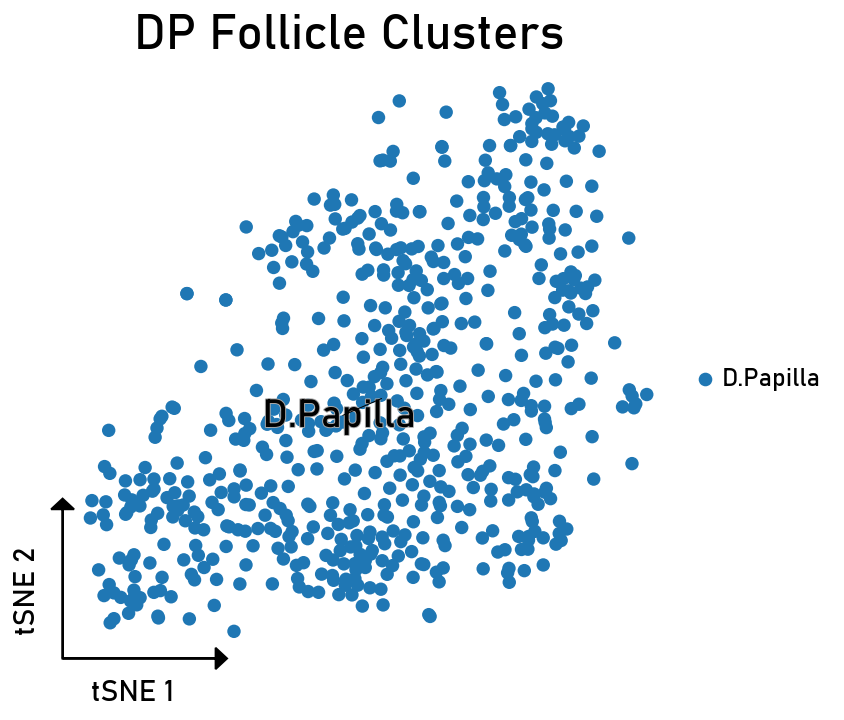

In [12]:
ax = plot_tsne_with_labels(adata_DP, color_var="FineClust", plot_title = "DP Follicle Clusters", legend_fontsize = 20, figsize = (6,6))

/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)



Top 5 genes for Anagen:
FOS: score=6.36, log2FC=1.14
CXCL14: score=6.15, log2FC=1.94
JUN: score=4.48, log2FC=0.83
ENSG00000289474: score=4.42, log2FC=0.56
NR4A1: score=3.51, log2FC=0.77

Top 5 genes for Catagen:
CACNA1C: score=6.48, log2FC=1.69
KAZN: score=6.31, log2FC=1.10
HSPA5: score=5.37, log2FC=1.57
OSBPL8: score=5.27, log2FC=1.00
MMP14: score=5.27, log2FC=1.77

Top 5 genes for Telogen:
PLCG2: score=6.34, log2FC=1.18
COL3A1: score=5.92, log2FC=1.21
LINC00486: score=4.84, log2FC=1.56
MMP16: score=4.60, log2FC=1.48
LAMB1: score=4.46, log2FC=1.03


<Figure size 840x700 with 0 Axes>

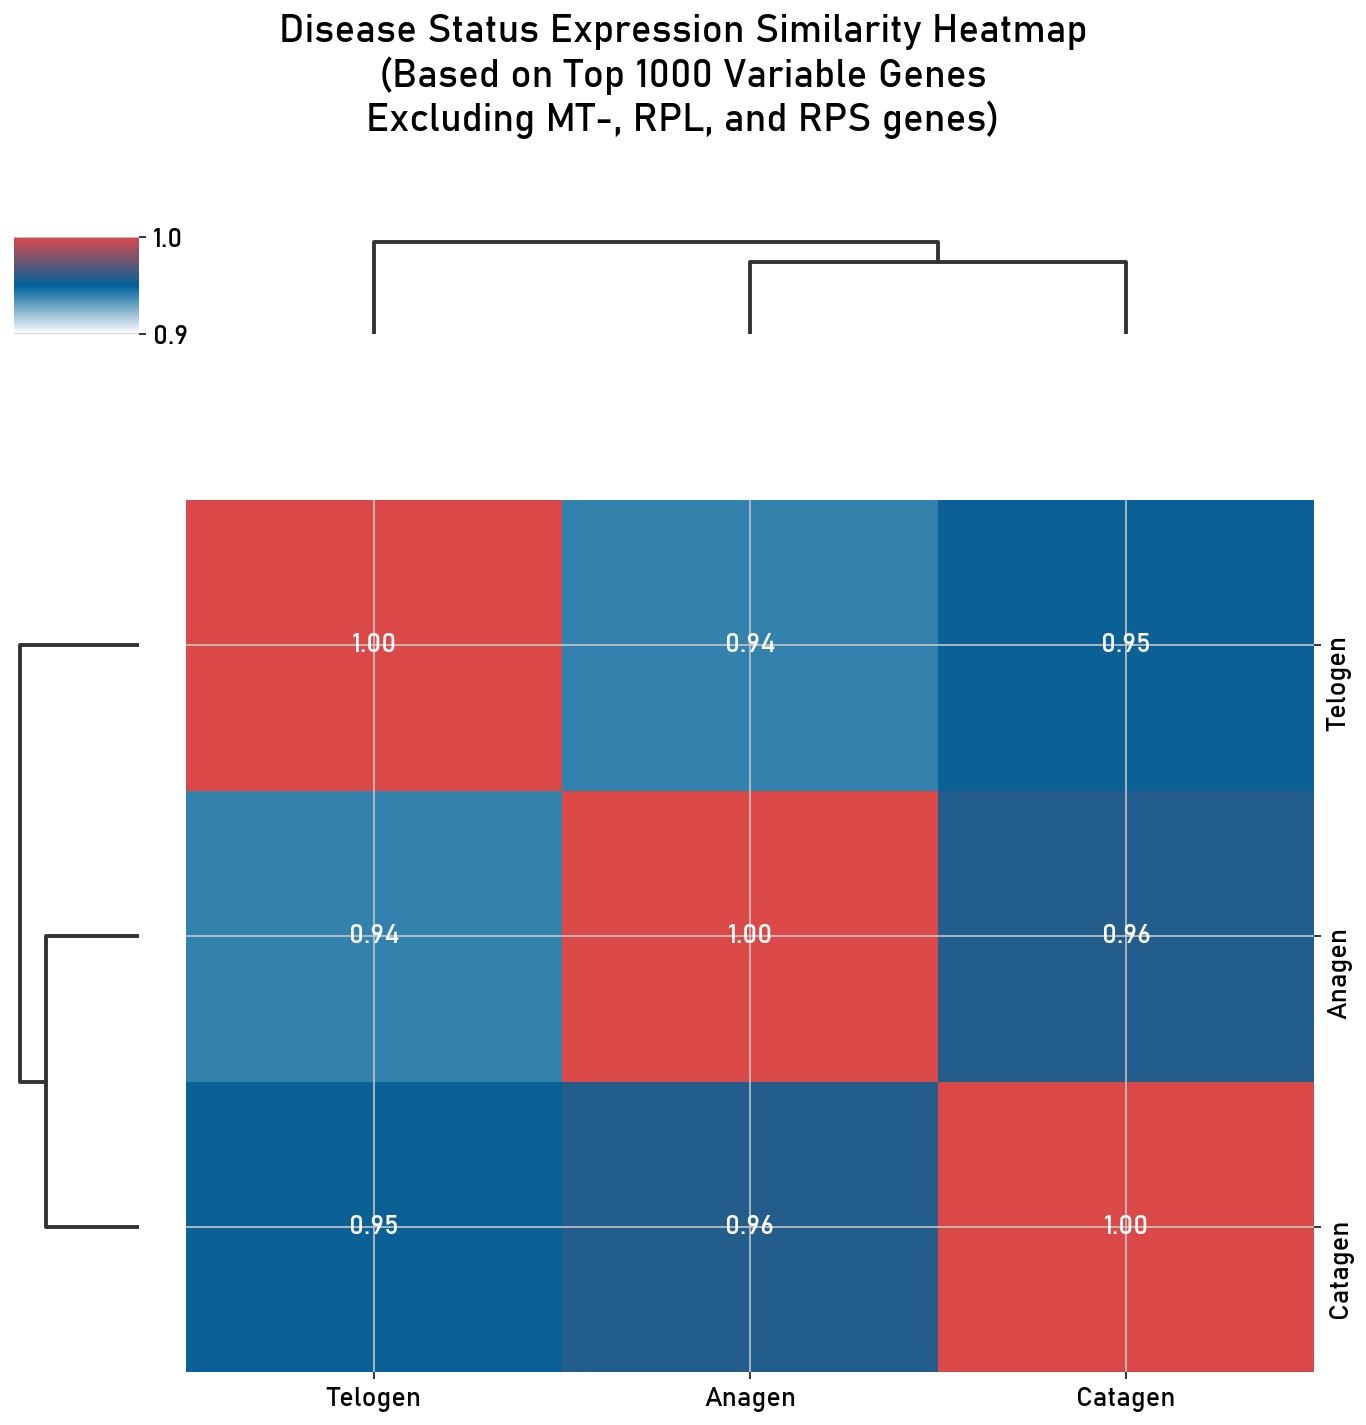

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import spmatrix
import seaborn as sns
import scanpy as sc

def filter_genes(adata, blacklist_patterns=['MT-', 'RPL', 'RPS']):
    """
    Create a boolean mask for genes to keep (not matching blacklist patterns).
    
    Parameters:
    adata: AnnData object
    blacklist_patterns: list of patterns to exclude
    
    Returns:
    keep_genes: boolean mask for genes to keep
    """
    gene_names = adata.var_names.str.upper()
    keep_genes = np.ones(len(gene_names), dtype=bool)
    
    for pattern in blacklist_patterns:
        keep_genes &= ~gene_names.str.startswith(pattern.upper())
    
    return keep_genes

def calculate_disease_status_expression_similarity(adata, status_to_keep, n_top_genes=1000):
    """
    Calculate similarity between disease statuses based on mean expression of top variable genes,
    excluding mitochondrial and ribosomal genes.
    
    Parameters:
    adata: AnnData object containing the single-cell data
    status_to_keep: list of disease status labels to analyze
    n_top_genes: number of top variable genes to consider
    
    Returns:
    similarity_matrix: pandas DataFrame containing pairwise similarities
    top_genes: list of selected highly variable genes
    """
    # Create a copy of adata to avoid modifying the original
    adata_filtered = adata.copy()
    
    # Filter out blacklisted genes
    keep_genes = filter_genes(adata_filtered)
    adata_filtered = adata_filtered[:, keep_genes]
    
    # Calculate highly variable genes on filtered data
    if 'highly_variable' not in adata_filtered.var:
        sc.pp.highly_variable_genes(adata_filtered, n_top_genes=n_top_genes, flavor='seurat')
    
    # Get the top variable genes
    top_genes = adata_filtered.var_names[adata_filtered.var.highly_variable][:n_top_genes].tolist()
    
    # Calculate mean expression for each disease status
    status_means = {}
    for status in status_to_keep:
        # Get cells belonging to this disease status
        status_cells = adata_filtered[adata_filtered.obs['diseaseStatus'] == status]
        # Calculate mean expression of top variable genes
        status_means[status] = status_cells[:, top_genes].X.mean(axis=0)
        
        # Convert sparse matrix to dense if necessary
        if isinstance(status_means[status], spmatrix):
            status_means[status] = status_means[status].toarray().flatten()
    
    # Create matrix of mean expressions
    expression_matrix = np.vstack([status_means[status] for status in status_to_keep])
    
    # Calculate correlation matrix
    correlation_matrix = np.corrcoef(expression_matrix)
    
    # Convert to similarity matrix (scale from 0 to 1)
    similarity_matrix = (correlation_matrix + 1) / 2
    
    # Convert to DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=status_to_keep,
        columns=status_to_keep
    )
    
    return similarity_df, top_genes

def plot_disease_status_similarity_heatmap(similarity_df, figsize=(12, 10), vmin=0.9, vmax=1.0):
    """
    Create a heatmap visualization of the expression-based similarity matrix
    between disease statuses.
    
    Parameters:
    similarity_df: pandas DataFrame containing pairwise similarities
    figsize: tuple specifying figure size
    vmin: minimum value for color scale (default: 0.7)
    vmax: maximum value for color scale (default: 1.0)
    """
    plt.figure(figsize=figsize)
    
    # Create clustermap
    g = sns.clustermap(
        similarity_df,
        annot=True,          # Show values in cells
        fmt='.2f',           # Format to 2 decimal places
        cmap='custom_wbr',     # Use a diverging colormap
        square=True,         # Make cells square
        vmin=vmin,           # Minimum value
        vmax=vmax,           # Maximum value
        dendrogram_ratio=0.1,
        tree_kws={'linewidth': 2},
        colors_ratio=0
    )

    # Add title
    g.fig.suptitle('Disease Status Expression Similarity Heatmap\n(Based on Top 1000 Variable Genes\nExcluding MT-, RPL, and RPS genes)', 
                   y=1.02, 
                   fontsize=20)
    
    plt.tight_layout()
    
    return g.fig

def analyze_disease_status_genes(adata, status_to_keep, top_genes, n_genes_display=10):
    """
    Analyze and display the top differentially expressed genes between disease statuses.
    
    Parameters:
    adata: AnnData object
    status_to_keep: list of disease status labels
    top_genes: list of highly variable genes used in similarity analysis
    n_genes_display: number of top genes to display for each status
    """
    # Create a copy with filtered genes
    adata_filtered = adata[:, filter_genes(adata)].copy()
    
    results = []
    
    for status in status_to_keep:
        # Perform differential expression analysis
        sc.tl.rank_genes_groups(
            adata_filtered,
            groupby='diseaseStatus',
            groups=[status],
            reference='rest',
            method='wilcoxon'
        )
        
        # Get top genes for this disease status
        top_status_genes = pd.DataFrame(
            sc.get.rank_genes_groups_df(adata_filtered, group=status)
            .head(n_genes_display)
        )
        
        results.append({
            'status': status,
            'top_genes': top_status_genes['names'].tolist(),
            'scores': top_status_genes['scores'].tolist(),
            'log2fc': top_status_genes['logfoldchanges'].tolist()
        })
    
    return results

status_to_keep = adata_DP.obs['diseaseStatus'].unique().tolist()

# Calculate similarities based on filtered gene expression
similarity_matrix, top_genes = calculate_disease_status_expression_similarity(
    adata_DP, 
    status_to_keep,
    n_top_genes=1000
)

# Create and display heatmap
plot_disease_status_similarity_heatmap(similarity_matrix)

plt.savefig(os.path.join(output_dir, 'D.Papilla_Similarity.png'), bbox_inches='tight')

# Analyze top differential genes
gene_analysis = analyze_disease_status_genes(
    adata_DP, 
    status_to_keep, 
    top_genes,
    n_genes_display=200
)

# Display results
for result in gene_analysis:
    print(f"\nTop 5 genes for {result['status']}:")
    for gene, score, log2fc in zip(result['top_genes'][:5], 
                                  result['scores'][:5], 
                                  result['log2fc'][:5]):
        print(f"{gene}: score={score:.2f}, log2FC={log2fc:.2f}")

In [14]:
sc.tl.dendrogram(adata_DP, cor_method='spearman', groupby = "diseaseStatus")
sc.tl.rank_genes_groups(adata_DP, groupby = "diseaseStatus")

/tmp/ipykernel_2041016/2096047908.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[group_col] = pd.Categorical(


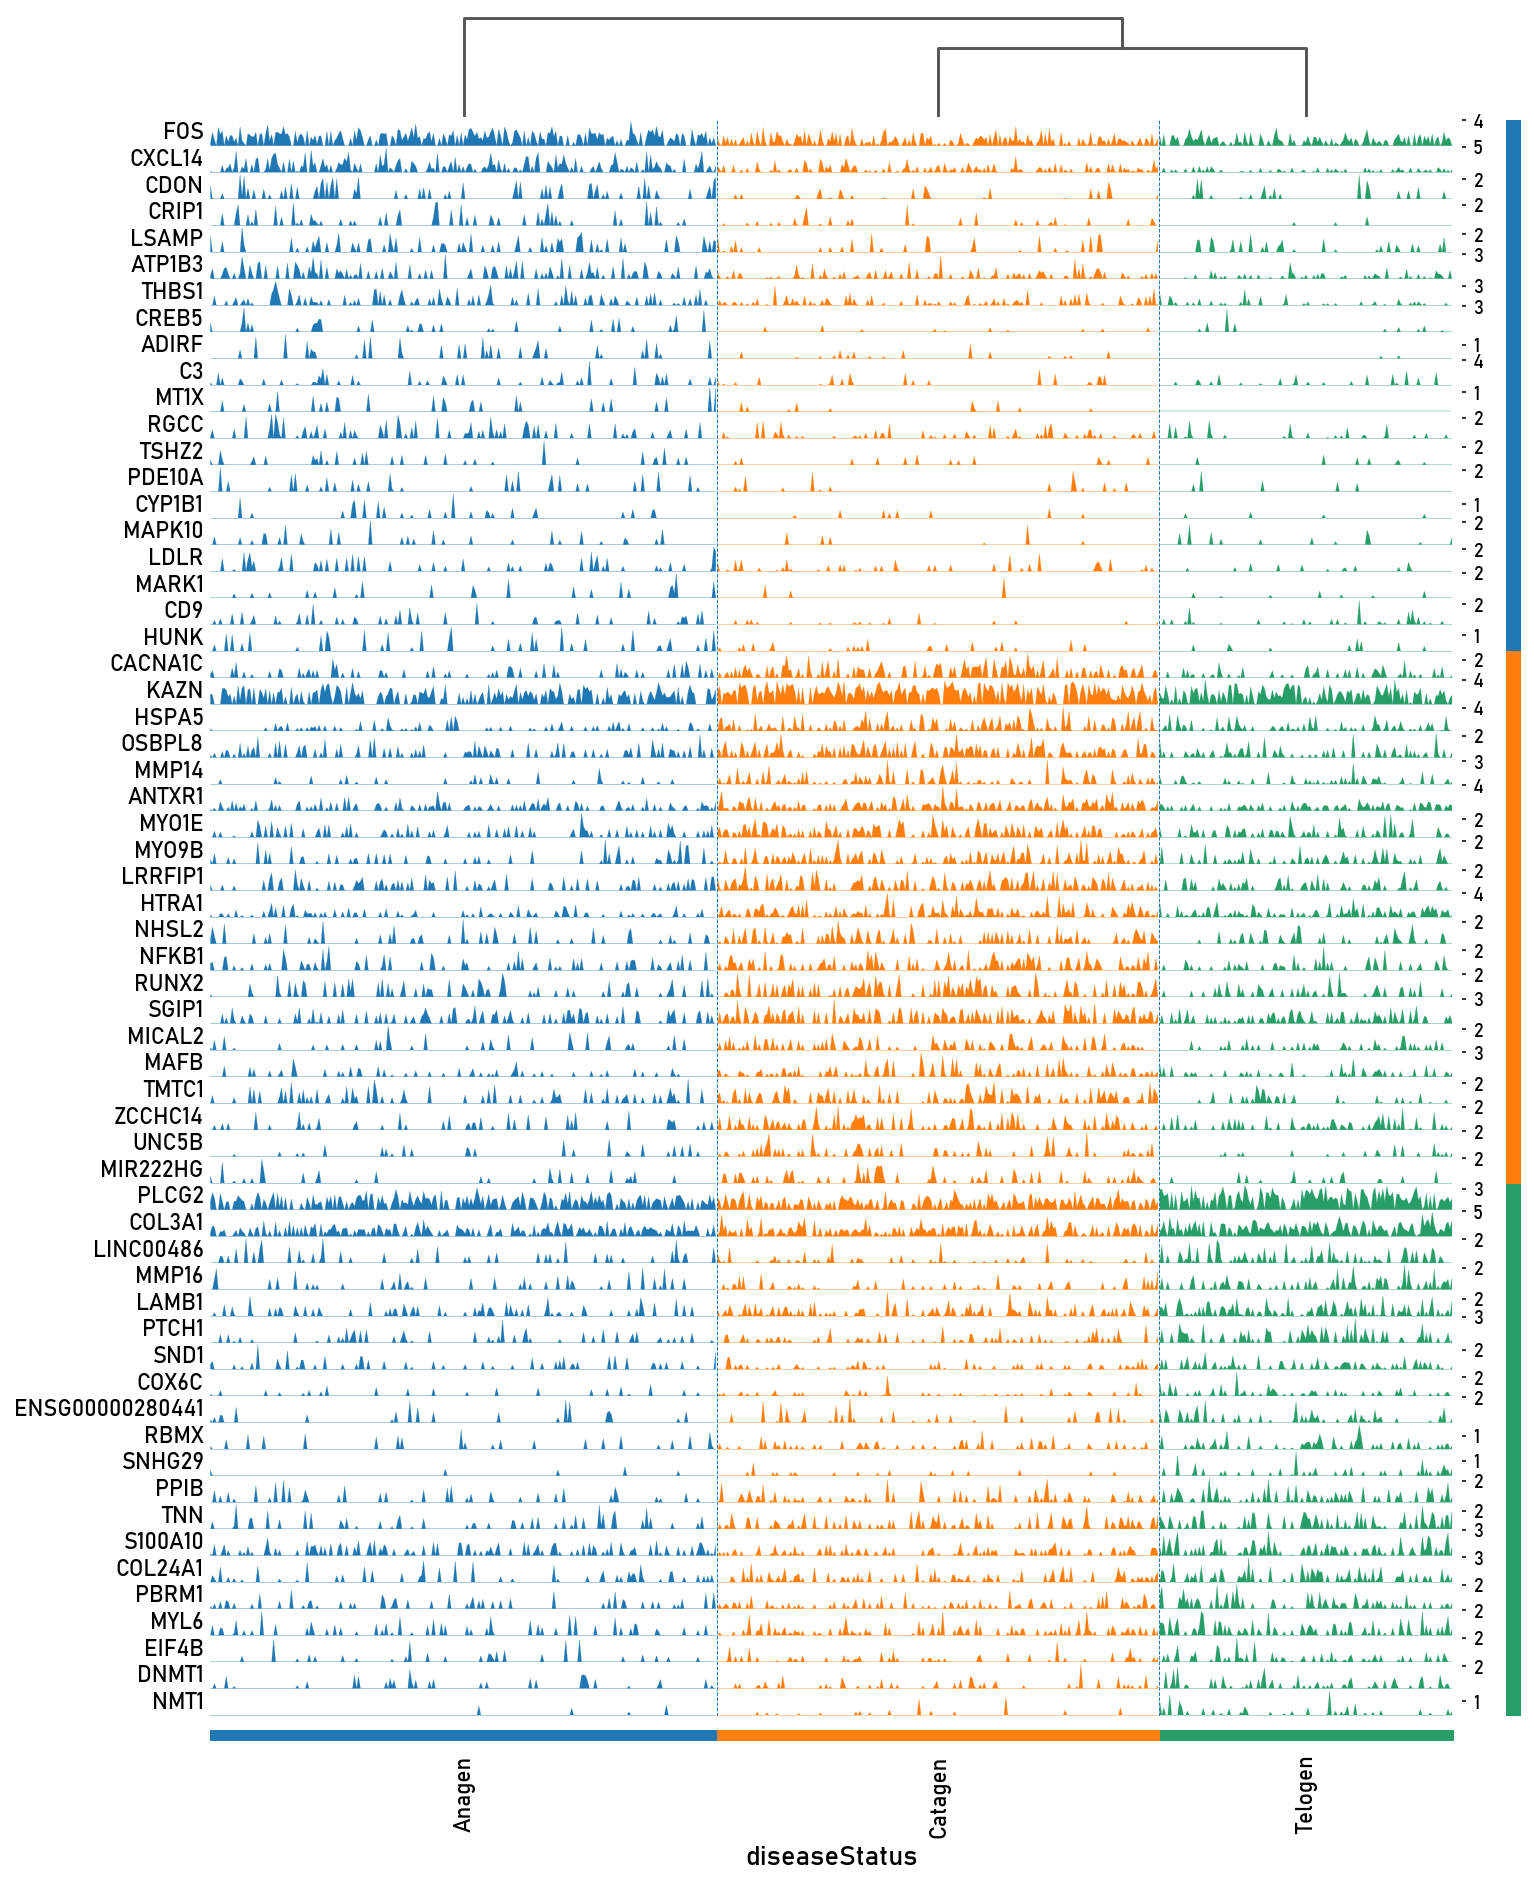

In [56]:
plt.rcParams['figure.figsize'] = [9, 12]

def plot_ranked_genes_custom_order(adata, group_col, custom_order):
    """
    Create a tracksplot with custom group ordering, excluding MT, RPL, and RPS genes.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix
    group_col : str
        Name of the column containing group information
    custom_order : list
        List of groups in desired order
    """
    # Make a copy to avoid modifying the original
    adata = adata.copy()
    
    # Filter out MT, RPL, and RPS genes
    gene_names = adata.var_names.str.upper()
    keep_genes = np.ones(len(gene_names), dtype=bool)
    
    # Define patterns to exclude
    blacklist_patterns = ['MT-', 'RPL', 'RPS']
    
    # Create mask for genes to keep
    for pattern in blacklist_patterns:
        keep_genes &= ~gene_names.str.startswith(pattern.upper())
    
    # Filter the AnnData object
    adata = adata[:, keep_genes]
    
    # Convert to categorical with custom order
    adata.obs[group_col] = pd.Categorical(
        adata.obs[group_col],
        categories=custom_order,
        ordered=True
    )
    
    # Run rank_genes_groups before plotting
    sc.tl.rank_genes_groups(adata, 
                           groupby=group_col,
                           method='wilcoxon',
                           pts=True)
    
    # Create the plot
    sc.pl.rank_genes_groups_tracksplot(
        adata,
        groupby=group_col,
        min_logfoldchange=1,
        n_genes = 20,
        save = "GeneTrackPlot_DP.png"
    )

# Example usage:
custom_order = ["Anagen", "Catagen", "Telogen"]
group_col = 'diseaseStatus'

plot_ranked_genes_custom_order(
    adata=adata_DP,
    group_col=group_col,
    custom_order=custom_order
)



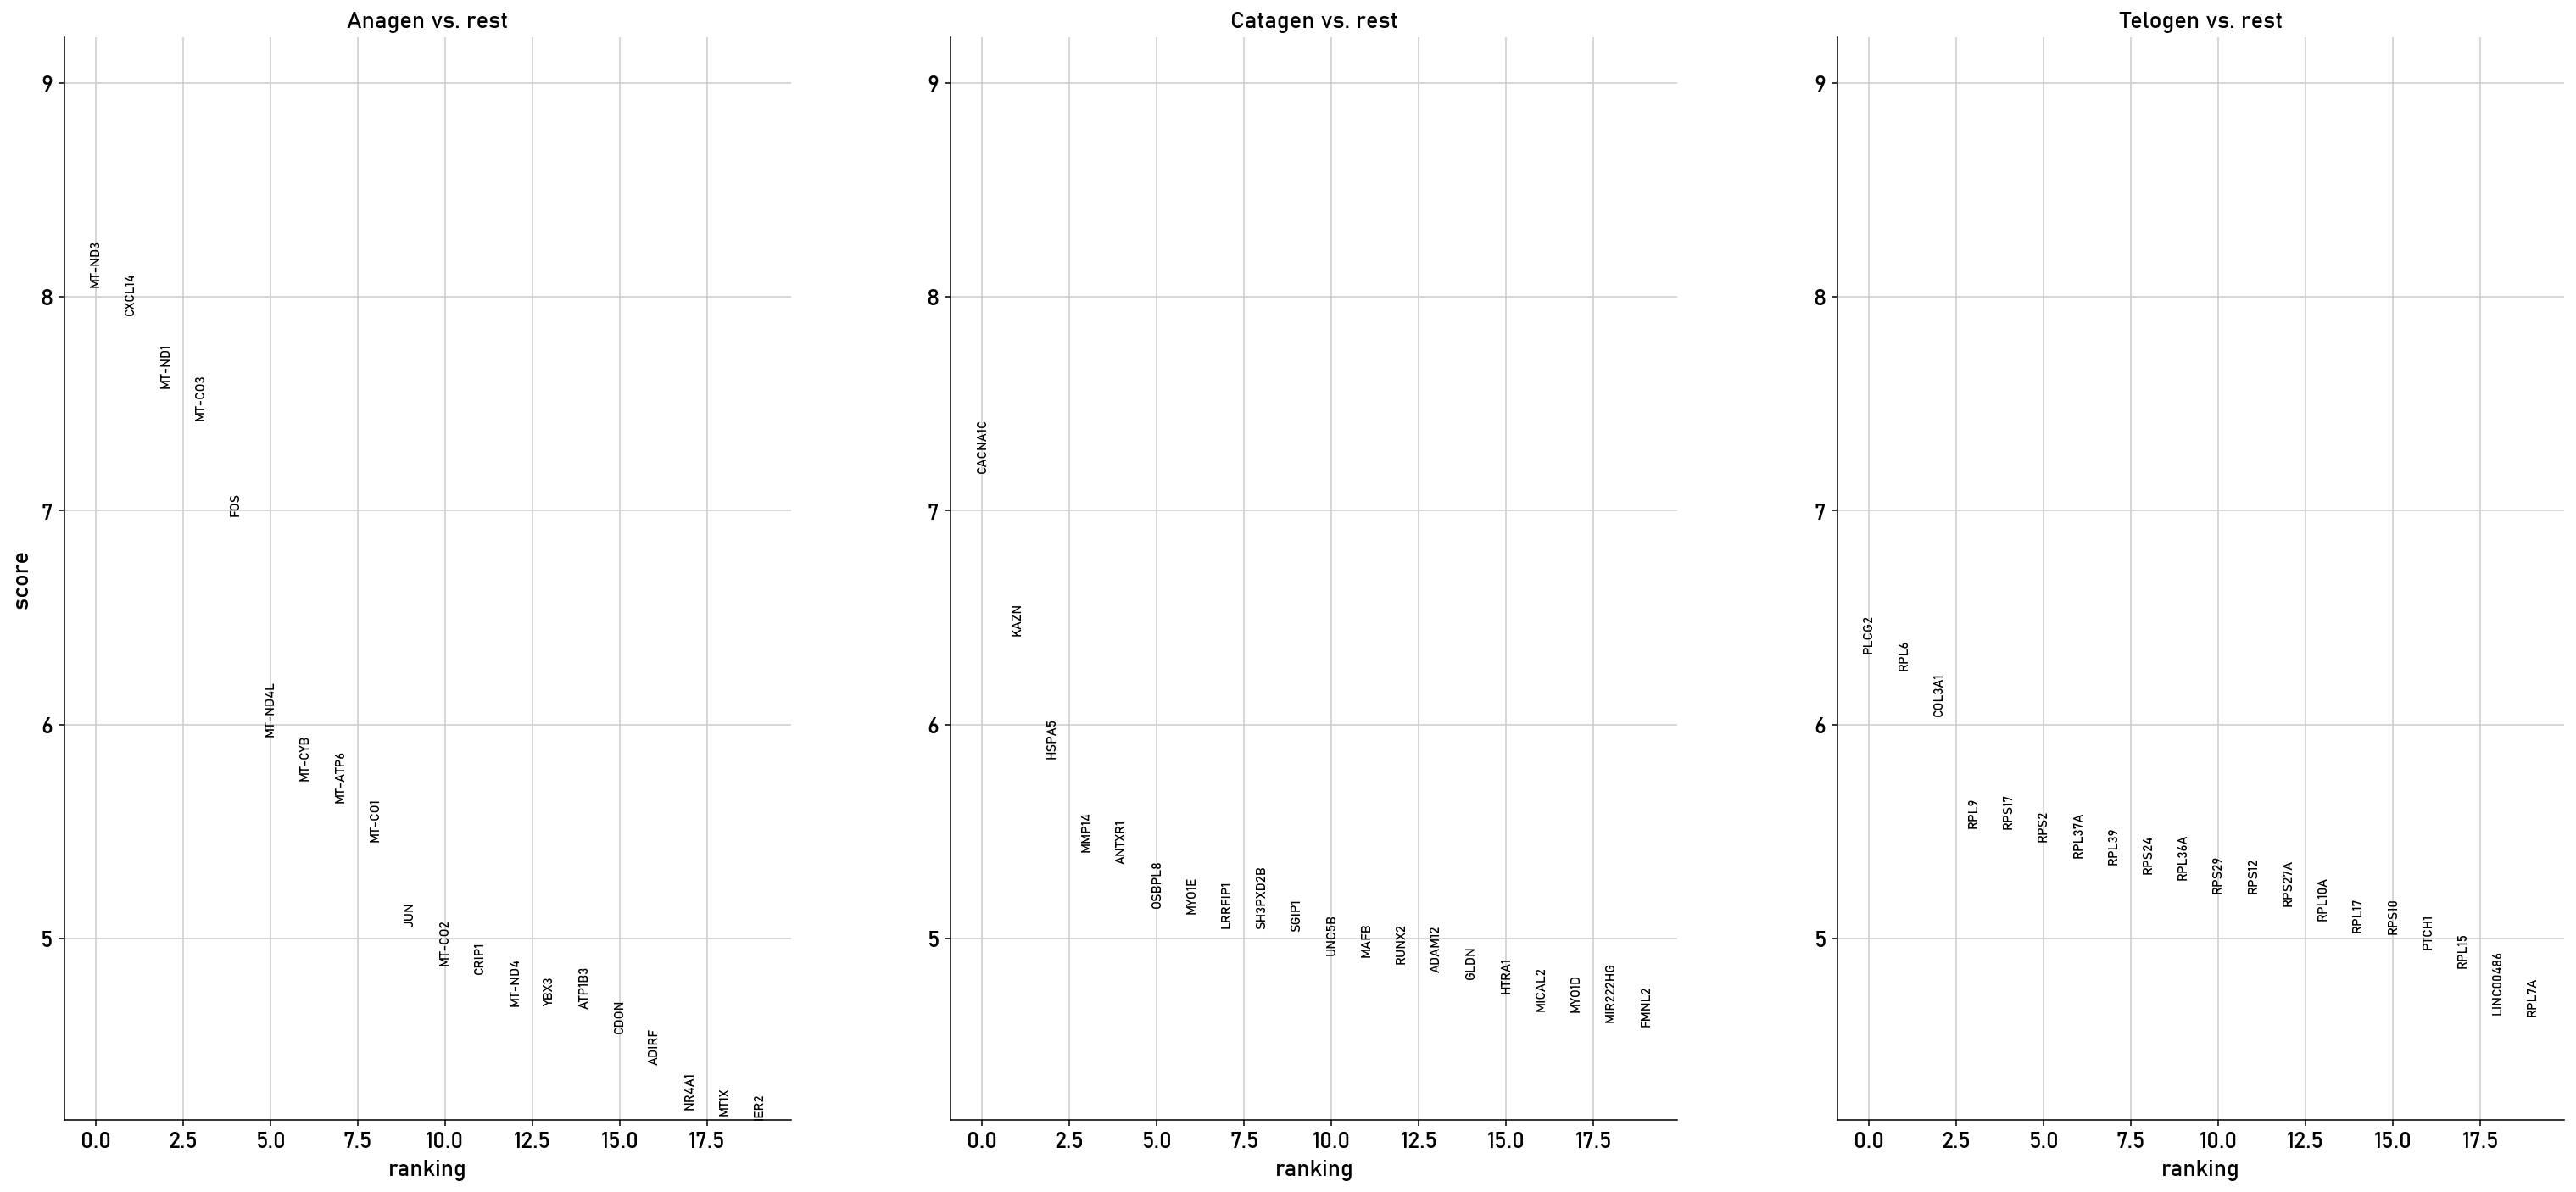

In [16]:
sc.pl.rank_genes_groups(adata_DP, n_genes=20)

In [18]:
category_map = {
    'Telogen': 2,
    'Anagen': 0,
    'Catagen': 1
}

adata_DP.obs['diseaseStatus_numeric'] = (
    adata_DP.obs['diseaseStatus']
    .map(category_map)
    .astype('float')
)

tp = TemporalProblem(adata_DP)
tp = tp.prepare(time_key="diseaseStatus_numeric")
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")
tmk = RealTimeKernel.from_moscot(tp, graph_key = "X_tsne")
print(adata_DP.obs['diseaseStatus_numeric'].value_counts())
tmk.compute_transition_matrix(adata = adata_DP, self_transitions="all", conn_weight=0.2, threshold="auto")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(257, 224)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(224, 149)].                                    
diseaseStatus_numeric
0.0    257
1.0    224
2.0    149
Name: count, dtype: int64


  0%|          | 0/2 [00:00<?, ?time pair/s]

RealTimeKernel[n=630, adata=AnnData object with n_obs × n_vars = 630 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'pANN_0.25_0.18_1115', 'DF.classifications_0.25_0.18_1115', 'Singlet', 'estConp', 'diseaseStatus', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'Clusters', 'NamedClust', 'BroadClust', 'SubGroup', 'sample', 'FineClust', 'BigClust', 'pANN_0.25_0.3_254', 'DF.classifications_0.25_0.3_254', 'pANN_0.25_0.27_160', 'DF.classifications_0.25_0.27_160', 'RNA_snn_res.0.5', 'diseaseStatus_numeric'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'tsne', 'diseaseStatus_colors', 'FineClust_colors', 'dendrogram_diseaseStatus', 'rank_genes_groups'
    obsm: 'X_umap', 'X_pca', 'X_tsne'
    varm: 'PCs', threshold='auto', self_transitions='all']

  0%|          | 0/100 [00:00<?, ?sim/s]

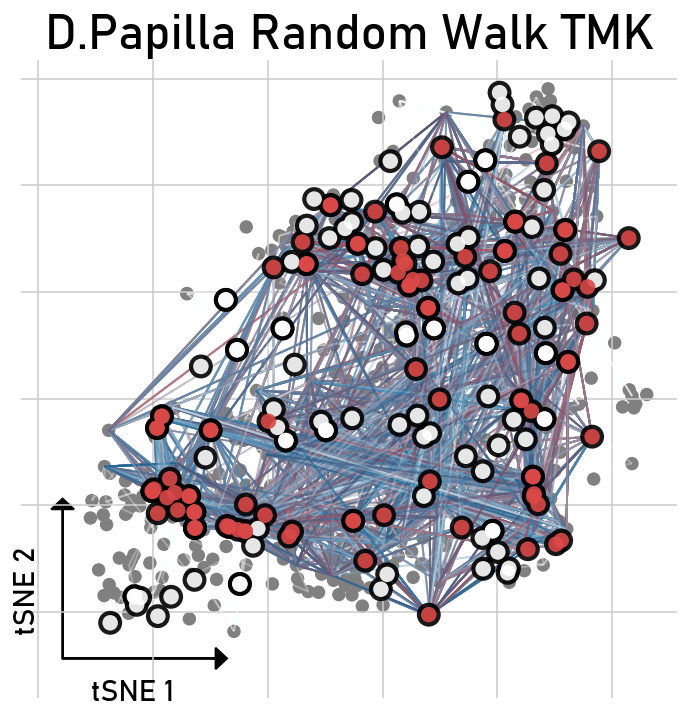

In [90]:
def plot_random_walk_tsne(adata_bulge, plot_title, figsize):
    """
    Create a tSNE plot with random walk TMK problem
    """
    # Call plot_random_walks
    tmk.plot_random_walks(
        max_iter=200,
        start_ixs={"diseaseStatus_numeric": 0.0},
        basis="tsne",
        seed=0,
        figsize=figsize,
        frameon=True,
        cmap="custom_wbr",
        xlabel="tSNE 1",
        ylabel="tSNE 2",
        title=plot_title,
        fontsize=20
    )
    
    # Get current axis
    ax = plt.gca()
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    # Set title and labels
    ax.set_title(plot_title, fontsize=25)
    ax.set_xlabel('tSNE 1', fontsize=15)
    ax.set_ylabel('tSNE 2', fontsize=15)
    ax.xaxis.set_label_coords(0.17, 0.03)
    ax.yaxis.set_label_coords(0.03, 0.17)
    
    # Get axis limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Add arrows
    arrow_props = dict(head_width=2, head_length=1, fc='k', ec='k')
    ax.arrow(xmin, ymin, 
            (xmax-xmin)/4, 0,
            **arrow_props)
    ax.arrow(xmin, ymin,
            0, (ymax-ymin)/4,
            **arrow_props)
            
    return ax

# Create the plot
ax = plot_random_walk_tsne(adata_DP, 
                          plot_title="D.Papilla Random Walk TMK", 
                          figsize=(6,6))

plt.savefig(os.path.join(output_dir, 'D.Papilla_RandomWalk.png'), bbox_inches='tight')

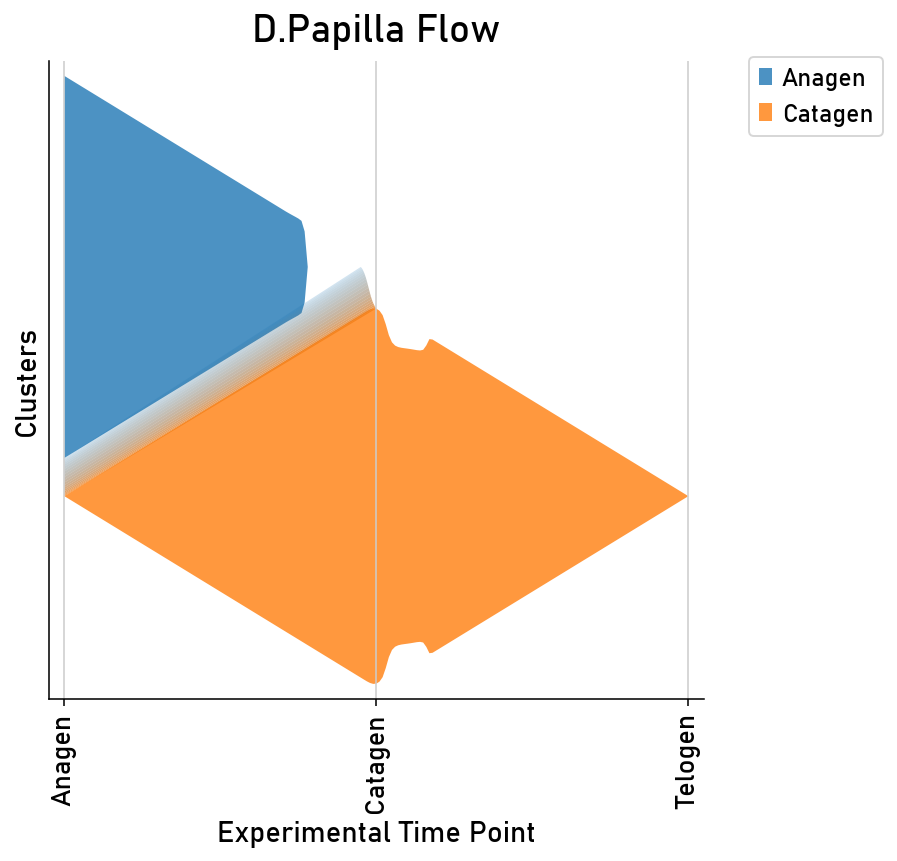

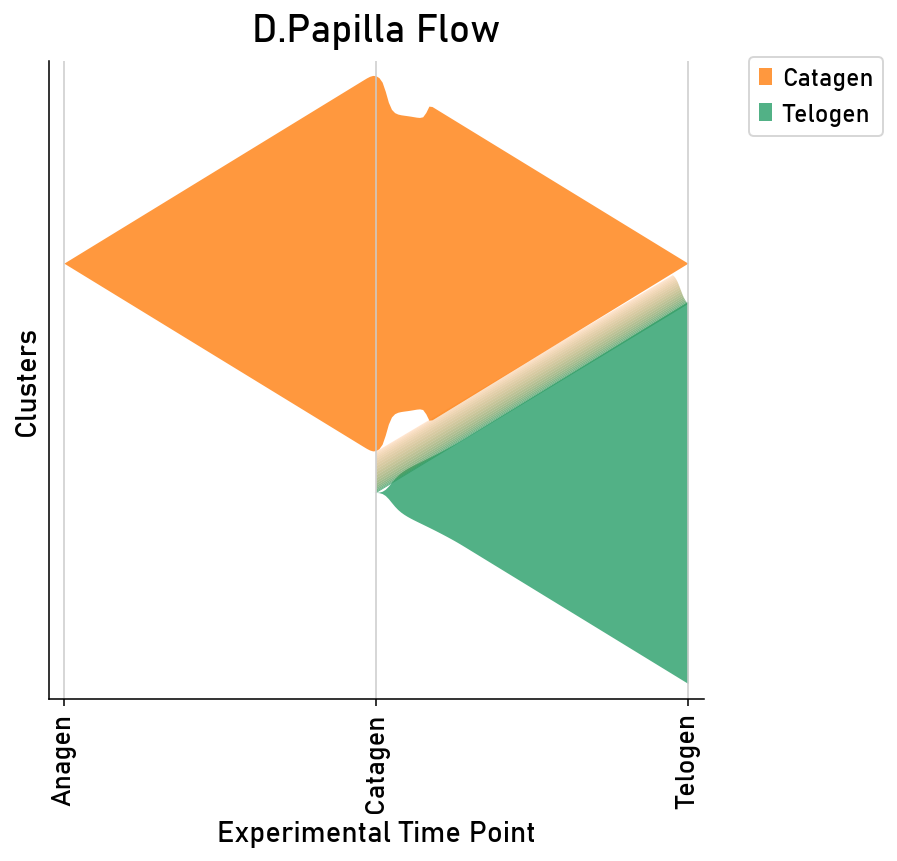

In [30]:
plt.rcParams['figure.figsize'] = [6, 6]

ax = tmk.plot_single_flow(
    cluster_key="diseaseStatus",
    time_key="diseaseStatus_numeric",
    cluster="Anagen",
    xticks_step_size=1,
    show=False,
    clusters = ["Anagen", "Catagen", "Telogen"]
)

ax.set_title("D.Papilla Flow", fontsize=20, pad = 10)
ax.set_xlabel('Experimental Time Point', fontsize=15)
ax.set_xticklabels(['Anagen', 'Catagen', 'Telogen'])
ax.set_ylabel('Clusters', fontsize=15)



_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax = tmk.plot_single_flow(
    cluster_key="diseaseStatus",
    time_key="diseaseStatus_numeric",
    cluster="Catagen",
    xticks_step_size=1,
    show=False,
    clusters=["Anagen", "Catagen", "Telogen"]
)

ax.set_title("D.Papilla Flow", fontsize=20, pad = 10)
ax.set_xlabel('Experimental Time Point', fontsize=15)
ax.set_xticklabels(['Anagen', 'Catagen', 'Telogen'])
ax.set_ylabel('Clusters', fontsize=15)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [32]:
sc.pp.neighbors(adata_DP)
sc.tl.diffmap(adata_DP)

anagen_cells = adata_DP.obs[adata_DP.obs['diseaseStatus'] == 'Anagen'].index
root_cell_idx = adata_DP.obs.index.get_indexer([anagen_cells[0]])[0]
adata_DP.uns['iroot'] = root_cell_idx

sc.tl.dpt(adata_DP)

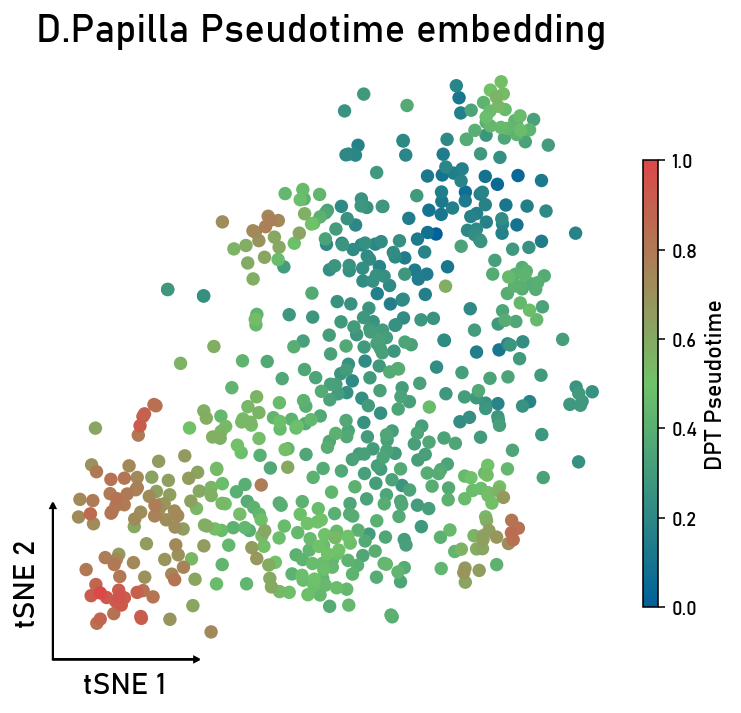

In [78]:
def plot_embedding_time(adata, plot_title, color_var, legend_fontsize, figsize=(6, 6), basis = "umap", continuous_cmap='custom_btr', colorbar_label="Pseudotime"):
    """
    Create a UMAP for embedding key, handling both categorical and continuous variables
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix
    plot_title : str
        Title for the plot
    color_var : str
        Variable to color by (can be categorical or continuous)
    legend_fontsize : int
        Font size for legend
    figsize : tuple
        Figure size
    continuous_cmap : str
        Colormap to use for continuous variables
    colorbar_label : str
        Label for the colorbar (default: "Pseudotime")
    """
    # Determine if variable is continuous or categorical
    is_continuous = (
        np.issubdtype(adata.obs[color_var].dtype, np.number) and 
        not pd.api.types.is_categorical_dtype(adata.obs[color_var])
    )
    
    # Call plot 
    with plt.rc_context({'figure.figsize': figsize}):
        if is_continuous:
            # For continuous variables
            sc.pl.embedding(
                adata=adata,
                basis=basis,
                frameon=True,
                title=plot_title,
                show=False,
                color=color_var,
                cmap=continuous_cmap
            )
            
            # Modify colorbar
            fig = plt.gcf()
            cbar_ax = fig.get_axes()[-1]  # Get the colorbar axis
            
            # Adjust colorbar size and position
            pos = cbar_ax.get_position()
            cbar_ax.set_position([pos.x0 + 0.02, pos.y0 + 0.1, pos.width * 0.7, pos.height * 0.7])
            
            # Set colorbar label
            cbar_ax.set_ylabel(colorbar_label, fontsize=12)
            
            # Adjust colorbar tick label size
            cbar_ax.tick_params(labelsize=10)
            
        else:
            # For categorical variables
            sc.pl.embedding(
                adata=adata,
                basis="umap",
                frameon=True,
                title=plot_title,
                show=False,
                color=color_var,
                legend_loc='on data',
                legend_fontsize=legend_fontsize
            )
    
    # Get current axis
    ax = plt.gca()
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    # Set title and labels
    ax.set_title(plot_title, fontsize=20)
    ax.set_xlabel('tSNE 1', fontsize=15)
    ax.set_ylabel('tSNE 2', fontsize=15)
    ax.xaxis.set_label_coords(0.17, 0.03)
    ax.yaxis.set_label_coords(0.03, 0.17)
    
    # Get axis limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Add arrows
    arrow_props = dict(head_width=.5, head_length=.5, fc='k', ec='k')
    ax.arrow(xmin, ymin, 
            (xmax-xmin)/4, 0,
            **arrow_props)
    ax.arrow(xmin, ymin,
            0, (ymax-ymin)/4,
            **arrow_props)
    
    # Only add text labels for categorical variables
    if not is_continuous:
        texts = []
        for group in adata.obs[color_var].unique():
            mask = adata.obs[color_var] == group
            x = adata.obsm['X_umap'][mask, 0].mean()
            y = adata.obsm['X_umap'][mask, 1].mean()
            text = ax.text(x, y, str(group),
                         fontsize=legend_fontsize,
                         path_effects=[pe.withStroke(linewidth=1, foreground="darkgray")],
                         ha='center',
                         va='center')
            texts.append(text)
    
    return ax

ax = plot_embedding_time(adata = adata_DP,
                              color_var = "dpt_pseudotime",
                              plot_title = "D.Papilla Pseudotime embedding",
                              colorbar_label = "DPT Pseudotime",
                              basis="tsne",
                              legend_fontsize = 15)

plt.savefig(os.path.join(output_dir, 'DP_Pseudotime_tSNE.png'), bbox_inches='tight')

In [34]:
g = cr.estimators.GPCCA(tmk)
g.fit(cluster_key="diseaseStatus", n_states=[3, 12])

GPCCA[kernel=RealTimeKernel[n=630], initial_states=None, terminal_states=None]

/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


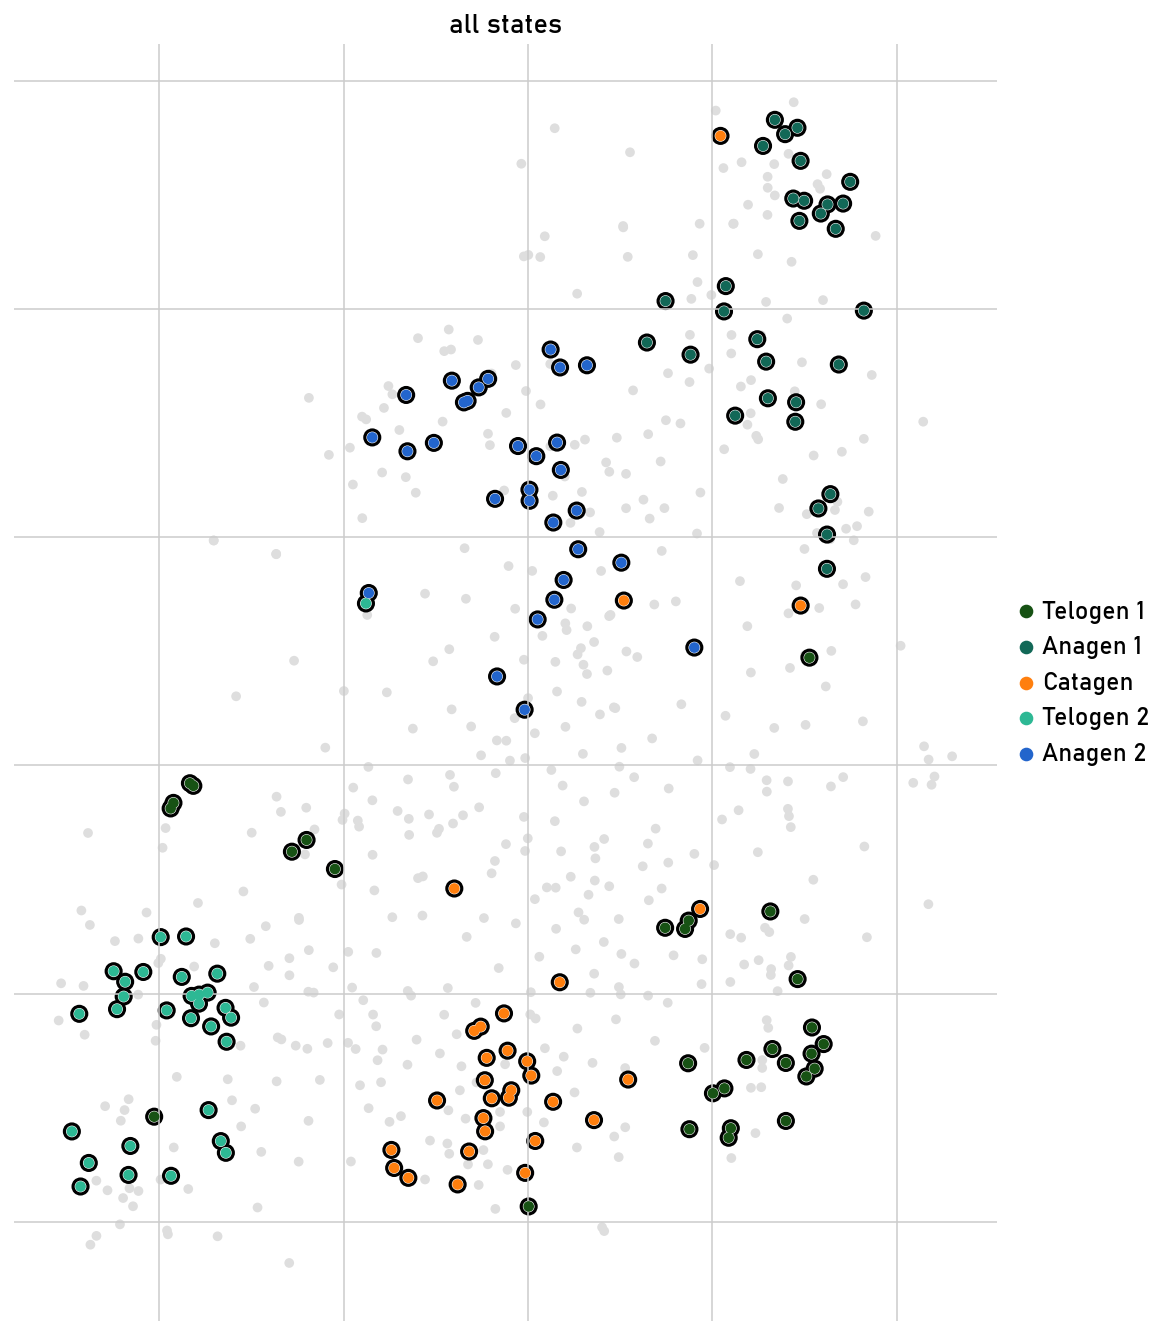

GPCCA[kernel=RealTimeKernel[n=630], initial_states=['Anagen_2'], terminal_states=['Telogen_2']]

In [59]:
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100, basis='tsne')

g.set_initial_states(states=["Anagen_2"])
g.set_terminal_states(states=["Telogen_2"])

/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/uvictor/miniconda3/envs/cellrank-palantir/lib/python3.12/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


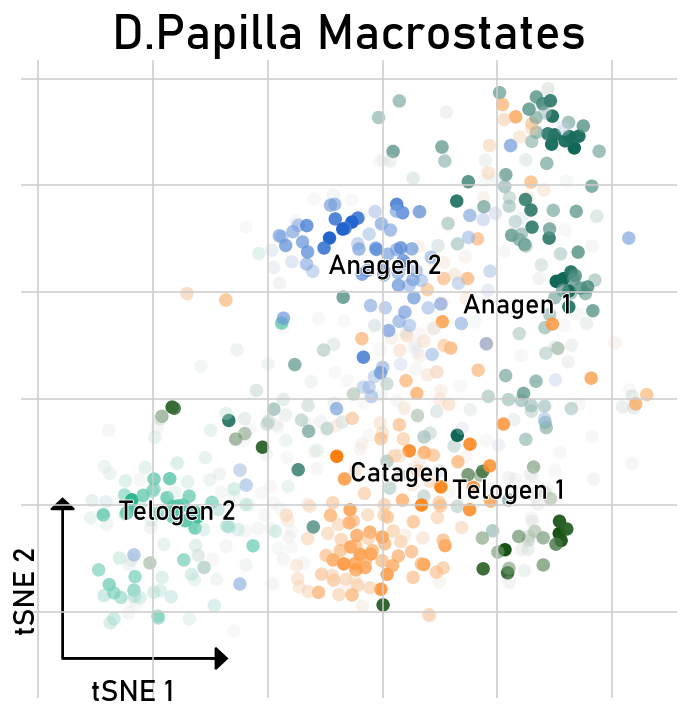

In [79]:
plt.rcParams['figure.figsize'] = [6, 6]

def plot_macrostates_tsne(adata, plot_title, figsize):
    """
    Create a tSNE plot for Macrostates
    """
    # Call plot_random_walks
    g.plot_macrostates(which="all", discrete=False, basis='tsne', show = False)
    
    # Get current axis
    ax = plt.gca()
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    # Set title and labels
    ax.set_title(plot_title, fontsize=25)
    ax.set_xlabel('tSNE 1', fontsize=15)
    ax.set_ylabel('tSNE 2', fontsize=15)
    ax.xaxis.set_label_coords(0.17, 0.03)
    ax.yaxis.set_label_coords(0.03, 0.17)
    
    # Get axis limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Add arrows
    arrow_props = dict(head_width=2, head_length=1, fc='k', ec='k')
    ax.arrow(xmin, ymin, 
            (xmax-xmin)/4, 0,
            **arrow_props)
    ax.arrow(xmin, ymin,
            0, (ymax-ymin)/4,
            **arrow_props)
            
    return ax

# Create the plot
ax = plot_macrostates_tsne(adata_DP, 
                          plot_title="D.Papilla Macrostates", 
                          figsize=(6,6))

plt.savefig(os.path.join(output_dir, 'D.Papilla_Macrostates.png'), bbox_inches='tight')

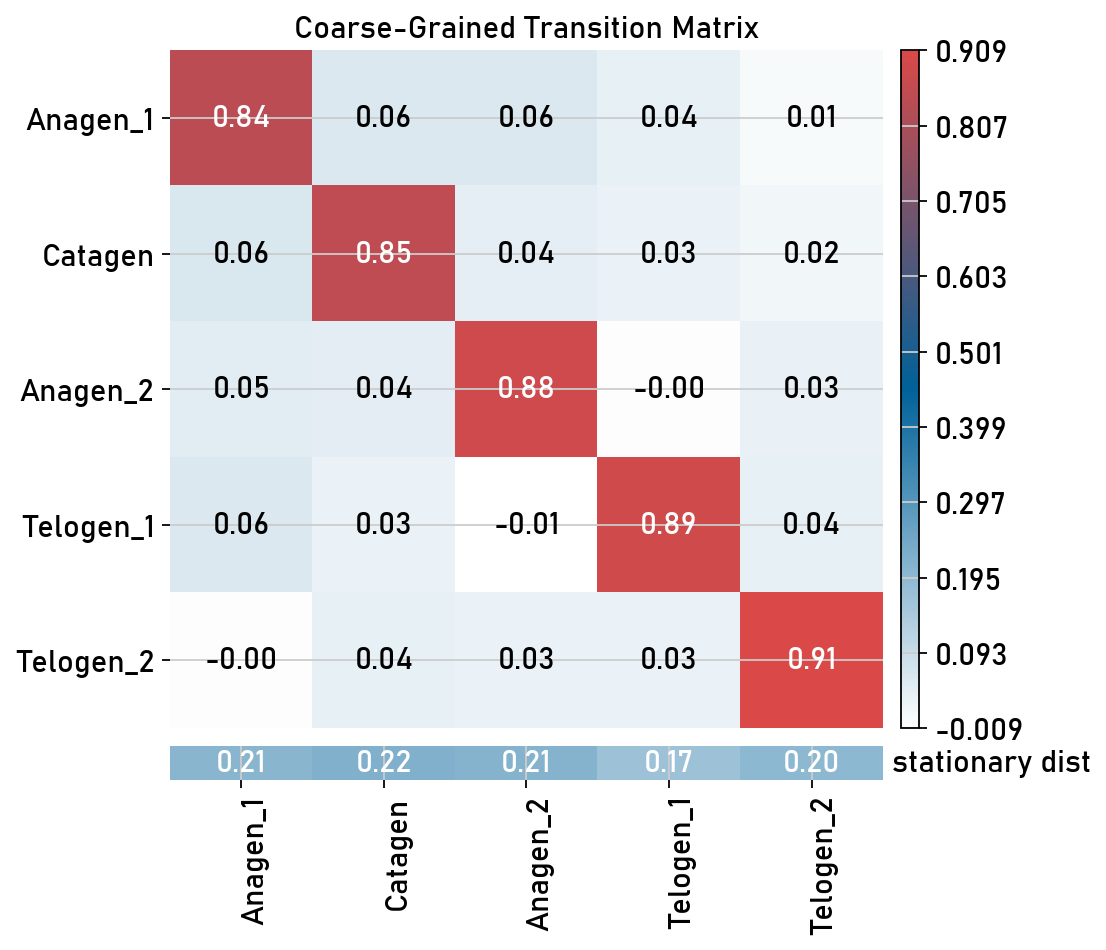

In [68]:
g.plot_coarse_T(title="Coarse-Grained Transition Matrix",
                figsize=(6,6),
                xtick_rotation = 90,
                cmap = "custom_wbr",
                save = os.path.join(output_dir, "DP_CoarseTMatrix.png")
)

In [81]:
g.compute_fate_probabilities()

  0%|          | 0/1 [00:00<?, ?/s]

In [85]:
g.compute_eigendecomposition()

driver_clusters = ["Anagen", "Catagen", "Telogen"] 

DP_df = g.compute_lineage_drivers(
    lineages=["Telogen_2"], cluster_key="diseaseStatus", clusters=driver_clusters
)

In [86]:
model = cr.models.GAMR(adata_DP, n_knots=6, smoothing_penalty=5.0)

  0%|          | 0/500 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


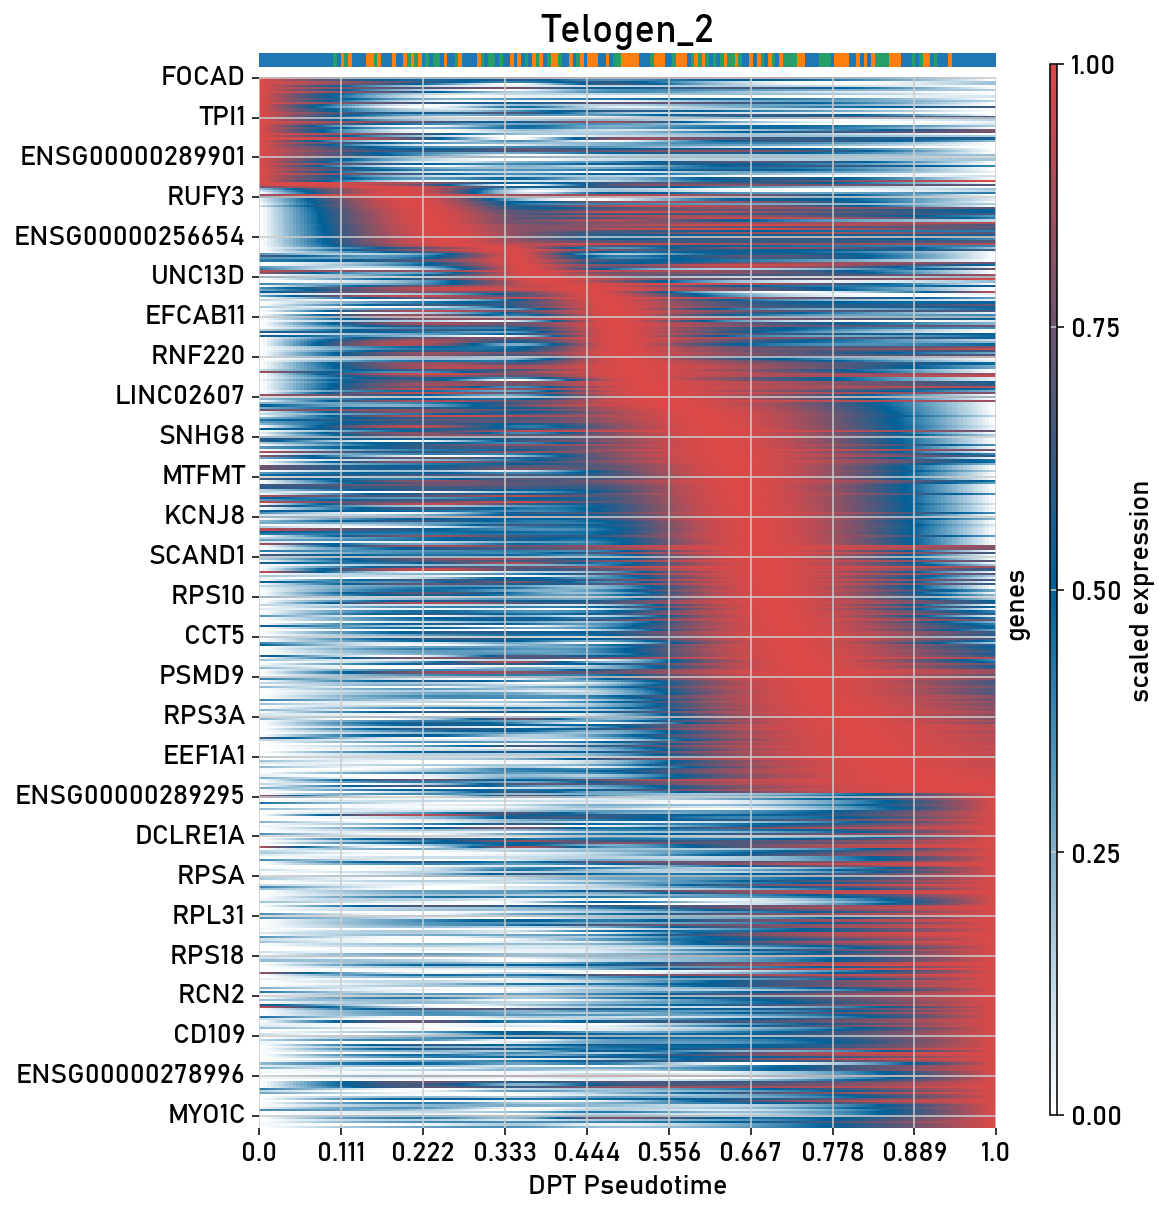

In [88]:
#Plot heatmap driver gene progression
cr.pl.heatmap(
    adata_DP,
    model=model,
    lineages="Telogen_2",
    cluster_key="diseaseStatus",
    genes=DP_df.head(500).index,
    time_key="dpt_pseudotime",
    fontsize = 20,
    xlabel = "DPT Pseudotime",
    figsize=(9, 10),
    show_all_genes=False,
    return_figure=False,
    weight_threshold=(1e-3, 1e-3),
    cmap = "custom_wbr",
    save = os.path.join(output_dir, "Telogen2_DP_DriverGenePseudotime.png")
)

In [160]:
adata_DP

AnnData object with n_obs × n_vars = 630 × 38606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'pANN_0.25_0.18_1115', 'DF.classifications_0.25_0.18_1115', 'Singlet', 'estConp', 'diseaseStatus', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'Clusters', 'NamedClust', 'BroadClust', 'SubGroup', 'sample', 'FineClust', 'BigClust', 'pANN_0.25_0.3_254', 'DF.classifications_0.25_0.3_254', 'pANN_0.25_0.27_160', 'DF.classifications_0.25_0.27_160', 'RNA_snn_res.0.5', 'diseaseStatus_numeric', 'macrostates_fwd', 'n_counts', 'clusters_gradients', 'init_states_fwd', 'init_states_fwd_probs', 'term_states_fwd', 'term_states_fwd_probs', 'dpt_pseudotime'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'tsne', 'diseaseStatus_colors', 'FineClust_colors', 'dendrogram_diseaseStatus', 'rank_genes_groups', 'neighbor